In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import gc

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [28]:
X_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
X_test  = pd.read_csv('../input/X_test.csv')

In [3]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [4]:
X_train.shape

(487680, 13)

In [5]:
print(X_train['measurement_number'].max(), X_train['measurement_number'].min())

127 0


In [6]:
print(X_train['series_id'].max(), X_train['series_id'].min())

3809 0


In [7]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [8]:
targets = y_train['surface'].value_counts().index
print(targets)
print(y_train['surface'].value_counts())

Index(['concrete', 'soft_pvc', 'wood', 'tiled', 'fine_concrete',
       'hard_tiles_large_space', 'soft_tiles', 'carpet', 'hard_tiles'],
      dtype='object')
concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


In [9]:
target_to_id = {}
id_to_target = {}

for target in targets:
    if target not in target_to_id:
        new_id = len(target_to_id)
        target_to_id[target] = new_id
        id_to_target[new_id] = target

In [10]:
target_to_id

{'concrete': 0,
 'soft_pvc': 1,
 'wood': 2,
 'tiled': 3,
 'fine_concrete': 4,
 'hard_tiles_large_space': 5,
 'soft_tiles': 6,
 'carpet': 7,
 'hard_tiles': 8}

In [11]:
y_id = []
for i in range(len(y_train)):
    y_id.append(target_to_id[y_train['surface'].values[i]])
y_id = np.asarray(y_id)

In [12]:
y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
5,5,1,tiled
6,6,34,soft_pvc
7,7,31,concrete
8,8,33,hard_tiles_large_space
9,9,11,tiled


from sklearn.preprocessing import OneHotEncoder
encorder = OneHotEncoder()

In [13]:
class_num = len(targets)

In [14]:
y_id_one = np.zeros((len(y_id), class_num))
for i in range(len(y_id)):
    y_id_one[i, y_id[i]] = 1 

In [15]:
def norm_quat(df):
    norm = (df['orientation_X']**2 + df['orientation_Y']**2 + df['orientation_Z']**2 + df['orientation_W']**2)**0.5
    df['orientation_X'] /= norm
    df['orientation_Y'] /= norm
    df['orientation_Z'] /= norm
    df['orientation_W'] /= norm
    return df

import math

def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def fe_step1 (df):
    """Quaternions to Euler Angles"""
    
    x = df['orientation_X'].values
    y = df['orientation_Y'].values
    z = df['orientation_Z'].values
    w = df['orientation_W'].values
    nx, ny, nz = np.zeros(len(x)), np.zeros(len(y)), np.zeros(len(z)),
    for i in tqdm(range(len(x))):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx[i] = xx
        ny[i] = yy
        nz[i] = zz
    
    df['euler_X'] = nx
    df['euler_Y'] = ny
    df['euler_Z'] = nz
    return df

In [29]:
X_train = norm_quat(X_train)
X_test = norm_quat(X_test)
X_train = fe_step1(X_train)
X_test = fe_step1(X_test)

100%|██████████| 488448/488448 [00:01<00:00, 290927.40it/s]


In [17]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z
0,0_0,0,0,-0.758531,-0.634351,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.758532,-0.634342,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.758528,-0.634348,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.758516,-0.634357,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.758522,-0.634352,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843197,-0.024785,1.396698


In [18]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,euler_X,euler_Y,euler_Z
0,0_0,0,0,-0.025773,-0.988644,-0.148011,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,2.844735,-0.014254,3.091598
1,0_1,0,1,-0.025683,-0.988624,-0.148161,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,2.844435,-0.014411,3.091804
2,0_2,0,2,-0.025617,-0.988610,-0.148260,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,2.844239,-0.014658,3.091976
3,0_3,0,3,-0.025566,-0.988625,-0.148171,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,2.844420,-0.014712,3.092086
4,0_4,0,4,-0.025548,-0.988663,-0.147920,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,2.844920,-0.014434,3.092079


In [19]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [30]:
def lowpass_filter(data, r=0.05):
    f_data = np.zeros_like(data)
    f_data[0] = data[0]
    for i in range(1, len(data)):
        if i % 128 == 0:
            f_data[i] = data[i]
        else:
            f_data[i] = r * data[i] + (1-r) * f_data[i-1]
    return f_data

In [31]:
for data in [X_train, X_test]:
    data['linear_acceleration_X'] = lowpass_filter(data['linear_acceleration_X'])
    data['linear_acceleration_Y'] = lowpass_filter(data['linear_acceleration_Y'])
    data['linear_acceleration_Z'] = lowpass_filter(data['linear_acceleration_Z'])
    data['angular_velocity_X'] = lowpass_filter(data['angular_velocity_X'])
    data['angular_velocity_Y'] = lowpass_filter(data['angular_velocity_Y'])
    data['angular_velocity_Z'] = lowpass_filter(data['angular_velocity_Z'])

series_id is 1659
1659    train surface is concrete
Name: surface, dtype: object


<Figure size 432x288 with 0 Axes>

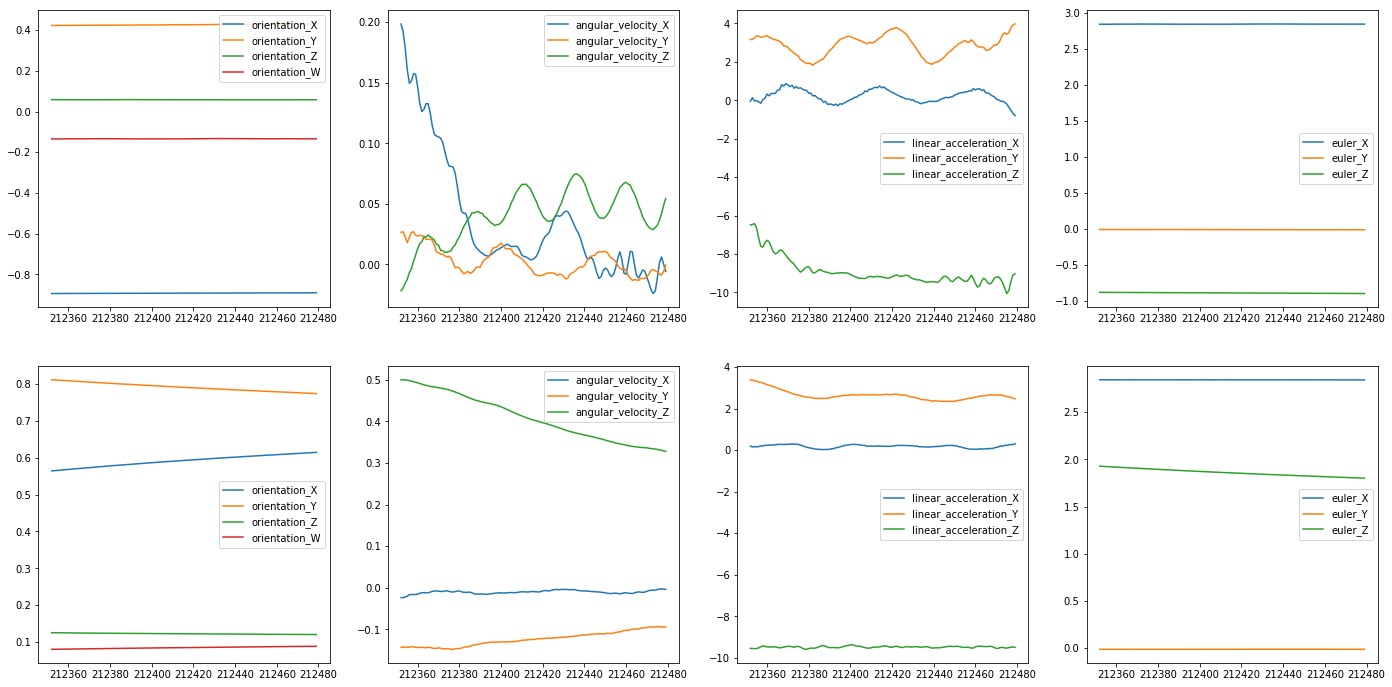

In [46]:
random_series = np.random.randint(X_train['series_id'].max())

X_tr = X_train[X_train['series_id'] == random_series]
X_te = X_test[X_test['series_id'] == random_series]

print('series_id is '+str(random_series))
print('train surface is '+y_train[y_train['series_id']==random_series]['surface'])
plt.figure()
fig, ax = plt.subplots(2, 4, figsize=(24,12))
plt.subplot(2, 4, 1)
plt.plot(X_tr['orientation_X'], label='orientation_X')
plt.plot(X_tr['orientation_Y'], label='orientation_Y')
plt.plot(X_tr['orientation_Z'], label='orientation_Z')
plt.plot(X_tr['orientation_W'], label='orientation_W')
plt.legend()

plt.subplot(2, 4, 2)
plt.plot(X_tr['angular_velocity_X'], label='angular_velocity_X')
plt.plot(X_tr['angular_velocity_Y'], label='angular_velocity_Y')
plt.plot(X_tr['angular_velocity_Z'], label='angular_velocity_Z')
plt.legend()

plt.subplot(2, 4, 3)
plt.plot(X_tr['linear_acceleration_X'], label='linear_acceleration_X')
plt.plot(X_tr['linear_acceleration_Y'], label='linear_acceleration_Y')
plt.plot(X_tr['linear_acceleration_Z'], label='linear_acceleration_Z')
plt.legend()

plt.subplot(2, 4, 4)
plt.plot(X_tr['euler_X'], label='euler_X')
plt.plot(X_tr['euler_Y'], label='euler_Y')
plt.plot(X_tr['euler_Z'], label='euler_Z')
plt.legend()

plt.subplot(2, 4, 5)
plt.plot(X_te['orientation_X'], label='orientation_X')
plt.plot(X_te['orientation_Y'], label='orientation_Y')
plt.plot(X_te['orientation_Z'], label='orientation_Z')
plt.plot(X_te['orientation_W'], label='orientation_W')
plt.legend()

plt.subplot(2, 4, 6)
plt.plot(X_te['angular_velocity_X'], label='angular_velocity_X')
plt.plot(X_te['angular_velocity_Y'], label='angular_velocity_Y')
plt.plot(X_te['angular_velocity_Z'], label='angular_velocity_Z')
plt.legend()

plt.subplot(2, 4, 7)
plt.plot(X_te['linear_acceleration_X'], label='linear_acceleration_X')
plt.plot(X_te['linear_acceleration_Y'], label='linear_acceleration_Y')
plt.plot(X_te['linear_acceleration_Z'], label='linear_acceleration_Z')
plt.legend()

plt.subplot(2, 4, 8)
plt.plot(X_te['euler_X'], label='euler_X')
plt.plot(X_te['euler_Y'], label='euler_Y')
plt.plot(X_te['euler_Z'], label='euler_Z')
plt.legend()

In [36]:
from scipy import signal

In [58]:
len(signal.find_peaks(X_tr['linear_acceleration_Y'])[0])

11

In [38]:
signal.find_peaks(X_tr['angular_velocity_X'])

(array([  5,   9,  11,  13,  18,  20,  24,  26,  28,  33,  37,  39,  43,
         48,  52,  56,  60,  64,  68,  80,  83,  93,  96, 103, 108, 111,
        113, 119, 123, 125]), {})

In [49]:
signal.peak_prominences(X_tr['linear_acceleration_X'], peaks=signal.find_peaks(X_tr['linear_acceleration_X'])[0])[0]

array([0.18144165, 0.01619434, 0.08956153, 0.00868478, 0.07532135,
       1.01652097, 0.07511307, 0.0860733 , 0.02993065, 0.01065556,
       0.02304319, 0.04529161, 0.01233348, 0.06320931, 0.02387552,
       0.0427538 , 0.0088163 , 0.0279869 , 1.02801403, 0.04571506,
       0.00901682, 0.0198002 , 0.02152567, 0.00743392, 0.02181276,
       0.01721872, 0.78239665, 0.05970646, 0.05306983, 0.01019378])

In [53]:
signal.peak_widths(X_tr['angular_velocity_X'], peaks=signal.find_peaks(X_tr['angular_velocity_X'])[0], rel_height=1.0)[0]

array([ 3.70498154,  3.85493029, 16.56912387,  2.68764569,  1.64232965,
       30.11194871,  2.02426835,  5.05499035,  5.98197647, 23.17315197,
        4.08402483,  3.58070693])

In [19]:
from sklearn.preprocessing import MinMaxScaler

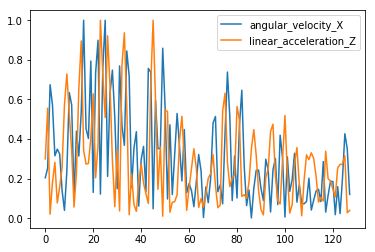

In [29]:
scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler.fit(X_tr['angular_velocity_X'])
X_tr_angXlinZ = scaler.fit_transform(pd.concat((X_tr['angular_velocity_X'], X_tr['linear_acceleration_Z']), axis=1))
#X_tr_linZ = scaler.fit_transform(X_tr['linear_acceleration_Z'])

plt.figure()
plt.plot(np.abs(X_tr_angXlinZ[:, 0]), label='angular_velocity_X')
plt.plot(np.abs(X_tr_angXlinZ[:, 1]), label='linear_acceleration_Z')
plt.legend()

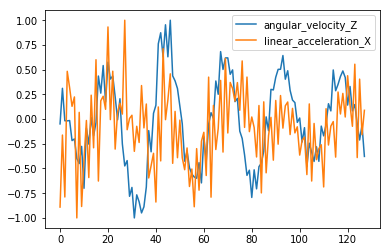

In [21]:
plt.figure()

X_tr_plt = pd.concat((X_tr['angular_velocity_Z'], X_tr['linear_acceleration_X']), axis=1)
#X_tr_plt['angular_velocity_X'] = np.cos(X_tr_plt['angular_velocity_X'])
X_tr_plt = scaler.fit_transform(X_tr_plt)

plt.plot(X_tr_plt[:, 0], label='angular_velocity_Z')
plt.plot(X_tr_plt[:, 1], label='linear_acceleration_X')

plt.legend()

In [30]:
np.correlate(np.abs(X_tr_angXlinZ[:, 0]), np.abs(X_tr_angXlinZ[:, 1]))

array([12.12990732])

In [40]:
X_train['euler_X'].describe()

count    487680.000000
mean          2.842559
std           0.012617
min           2.778661
25%           2.837915
50%           2.841058
75%           2.844004
max           2.917180
Name: euler_X, dtype: float64

In [41]:
X_test['euler_X'].describe()

count    488448.000000
mean          2.841983
std           0.004527
min           2.807038
25%           2.839163
50%           2.841944
75%           2.844751
max           2.870387
Name: euler_X, dtype: float64

In [42]:
X_train['euler_Y'].describe()

count    487680.000000
mean         -0.014035
std           0.003923
min          -0.032360
25%          -0.016353
50%          -0.014006
75%          -0.011416
max           0.010733
Name: euler_Y, dtype: float64

In [43]:
X_test['euler_Y'].describe()

count    488448.000000
mean         -0.013741
std           0.003838
min          -0.031574
25%          -0.015905
50%          -0.013672
75%          -0.011325
max           0.004289
Name: euler_Y, dtype: float64

In [44]:
X_train['euler_Z'].describe()

count    487680.000000
mean         -0.278371
std           1.802029
min          -3.141588
25%          -1.752289
50%          -0.798362
75%           1.423355
max           3.141576
Name: euler_Z, dtype: float64

In [45]:
X_test['euler_Z'].describe()

count    488448.000000
mean          0.115057
std           1.840599
min          -3.141574
25%          -1.436005
50%           0.163782
75%           1.944388
max           3.141579
Name: euler_Z, dtype: float64

In [48]:
from mpl_toolkits.mplot3d import axes3d 

In [51]:
plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X_train['euler_X'], X_train['euler_Y'], X_train['euler_Z'])
plt.show()

<Figure size 432x288 with 0 Axes>

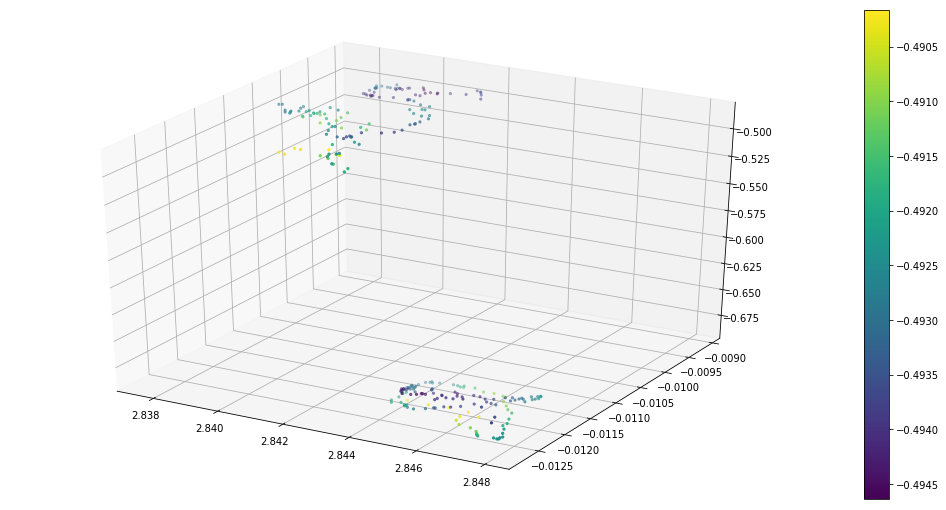

In [70]:
fig = plt.figure(figsize=(18, 9))
ax = fig.gca(projection='3d')    # <- axes3dをインポートしていないとエラーになる。
scatter = ax.scatter3D(X_train['euler_X'][128:128*2], X_train['euler_Y'][128:128*2], X_train['euler_Z'][128:128*2],
                       s=5,                    # マーカーのサイズ
                       c=X_train['euler_Z'][128:128*2],                    # 色分けに使う数値（任意の数値を指定可）
                       cmap=plt.cm.viridis)    # 色のパターン
scatter = ax.scatter3D(X_test['euler_X'][128:128*2], X_test['euler_Y'][128:128*2], X_test['euler_Z'][128:128*2],
                       s=5,                    # マーカーのサイズ
                       c=X_train['euler_Z'][128:128*2],                    # 色分けに使う数値（任意の数値を指定可）
                       cmap=plt.cm.viridis)
plt.colorbar(scatter)                          # カラーバーを表示（省略可）
plt.show()

In [71]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [80]:
y_train[y_train['surface']=='fine_concrete']['group_id'].value_counts()

72    70
68    70
48    70
35    57
13    57
36    36
30     3
Name: group_id, dtype: int64

In [81]:
y_train[y_train['group_id']==72]

,series_id,group_id,surface
1750,1750,72,fine_concrete
1760,1760,72,fine_concrete
1763,1763,72,fine_concrete
1768,1768,72,fine_concrete
1817,1817,72,fine_concrete
1891,1891,72,fine_concrete
1904,1904,72,fine_concrete
1931,1931,72,fine_concrete
1945,1945,72,fine_concrete
1950,1950,72,fine_concrete


series_id is 3782
3782    train surface is fine_concrete
Name: surface, dtype: object


<Figure size 432x288 with 0 Axes>

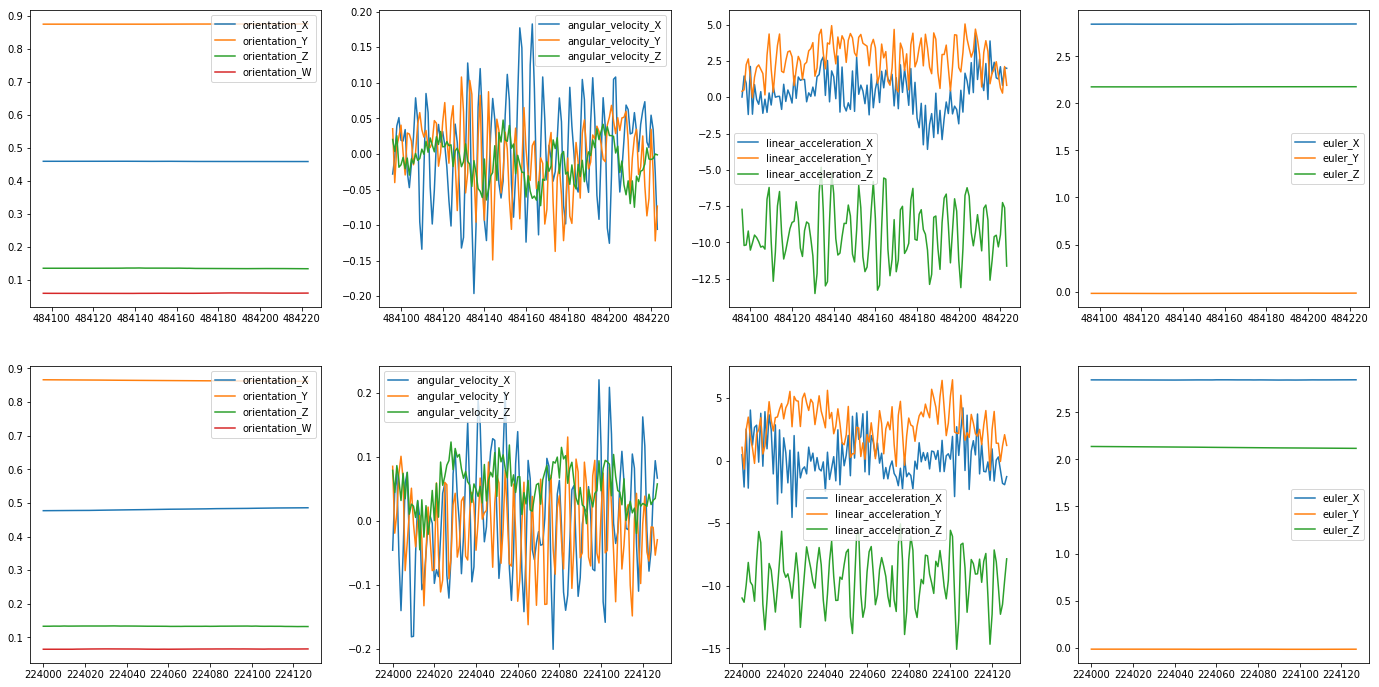

In [84]:
random_series = 3782

X_tr = X_train[X_train['series_id'] == random_series]
X_te = X_train[X_train['series_id'] == 1750]

print('series_id is '+str(random_series))
print('train surface is '+y_train[y_train['series_id']==random_series]['surface'])
plt.figure()
fig, ax = plt.subplots(2, 4, figsize=(24,12))
plt.subplot(2, 4, 1)
plt.plot(X_tr['orientation_X'], label='orientation_X')
plt.plot(X_tr['orientation_Y'], label='orientation_Y')
plt.plot(X_tr['orientation_Z'], label='orientation_Z')
plt.plot(X_tr['orientation_W'], label='orientation_W')
plt.legend()

plt.subplot(2, 4, 2)
plt.plot(X_tr['angular_velocity_X'], label='angular_velocity_X')
plt.plot(X_tr['angular_velocity_Y'], label='angular_velocity_Y')
plt.plot(X_tr['angular_velocity_Z'], label='angular_velocity_Z')
plt.legend()

plt.subplot(2, 4, 3)
plt.plot(X_tr['linear_acceleration_X'], label='linear_acceleration_X')
plt.plot(X_tr['linear_acceleration_Y'], label='linear_acceleration_Y')
plt.plot(X_tr['linear_acceleration_Z'], label='linear_acceleration_Z')
plt.legend()

plt.subplot(2, 4, 4)
plt.plot(X_tr['euler_X'], label='euler_X')
plt.plot(X_tr['euler_Y'], label='euler_Y')
plt.plot(X_tr['euler_Z'], label='euler_Z')
plt.legend()

plt.subplot(2, 4, 5)
plt.plot(X_te['orientation_X'], label='orientation_X')
plt.plot(X_te['orientation_Y'], label='orientation_Y')
plt.plot(X_te['orientation_Z'], label='orientation_Z')
plt.plot(X_te['orientation_W'], label='orientation_W')
plt.legend()

plt.subplot(2, 4, 6)
plt.plot(X_te['angular_velocity_X'], label='angular_velocity_X')
plt.plot(X_te['angular_velocity_Y'], label='angular_velocity_Y')
plt.plot(X_te['angular_velocity_Z'], label='angular_velocity_Z')
plt.legend()

plt.subplot(2, 4, 7)
plt.plot(X_te['linear_acceleration_X'], label='linear_acceleration_X')
plt.plot(X_te['linear_acceleration_Y'], label='linear_acceleration_Y')
plt.plot(X_te['linear_acceleration_Z'], label='linear_acceleration_Z')
plt.legend()

plt.subplot(2, 4, 8)
plt.plot(X_te['euler_X'], label='euler_X')
plt.plot(X_te['euler_Y'], label='euler_Y')
plt.plot(X_te['euler_Z'], label='euler_Z')
plt.legend()

In [48]:
X_train = np.asarray(X_train.iloc[:, 3:])
X_test = np.asarray(X_test.iloc[:, 3:])

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [66]:
X_train = X_train.reshape((-1, 128, 10))
X_test = X_test.reshape((-1, 128, 10))

In [67]:
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.


In [68]:
N_SPLITS = 5

In [69]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return weighted_input

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], self.features_dim

In [71]:
class_num = len(targets)

In [86]:
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
    x = Attention(input_shape[1])(x)
    
    x = Lambda(lambda x: K.sum(x, axis=1))(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
    x = Dense(64, activation="tanh")(x)
    
    out = Dense(class_num, activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)
  
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    
    return model

In [87]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_train, y_id))
preds_val = []
y_val = []
# Then, iteract with each fold
# If you dont know, enumerate(['a', 'b', 'c']) returns [(0, 'a'), (1, 'b'), (2, 'c')]
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session() # I dont know what it do, but I imagine that it "clear session" :)
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X_train[train_idx], y_id_one[train_idx], X_train[val_idx], y_id_one[val_idx]
    # instantiate the model for this fold
    model = model_lstm(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_categorical_accuracy', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 3044 samples, validate on 766 samples
Epoch 1/50
3044/3044 [==============================] - 25s 8ms/step - loss: 1.9699 - categorical_accuracy: 0.2618 - val_loss: 1.8872 - val_categorical_accuracy: 0.3394

Epoch 00001: val_categorical_accuracy improved from -inf to 0.33943, saving model to weights_0.h5
Epoch 2/50
3044/3044 [==============================] - 20s 6ms/step - loss: 1.7916 - categorical_accuracy: 0.3469 - val_loss: 1.7366 - val_categorical_accuracy: 0.3890

Epoch 00002: val_categorical_accuracy improved from 0.33943 to 0.38903, saving model to weights_0.h5
Epoch 3/50
3044/3044 [==============================] - 19s 6ms/step - loss: 1.6514 - categorical_accuracy: 0.4103 - val_loss: 1.6071 - val_categorical_accuracy: 0.4452

Epoch 00003: val_categorical_accuracy improved from 0.38903 to 0.44517, saving model to weights_0.h5
Epoch 4/50
3044/3044 [==============================] - 19s 6ms/step - loss: 1.5808 - categorical_accuracy: 0.4396 - val_loss:


Epoch 00033: val_categorical_accuracy improved from 0.57702 to 0.58225, saving model to weights_0.h5
Epoch 34/50
3044/3044 [==============================] - 19s 6ms/step - loss: 1.0404 - categorical_accuracy: 0.5897 - val_loss: 1.1457 - val_categorical_accuracy: 0.5509

Epoch 00034: val_categorical_accuracy did not improve from 0.58225
Epoch 35/50
3044/3044 [==============================] - 19s 6ms/step - loss: 1.0163 - categorical_accuracy: 0.5979 - val_loss: 1.0634 - val_categorical_accuracy: 0.5731

Epoch 00035: val_categorical_accuracy did not improve from 0.58225
Epoch 36/50
3044/3044 [==============================] - 19s 6ms/step - loss: 0.9878 - categorical_accuracy: 0.6176 - val_loss: 1.1049 - val_categorical_accuracy: 0.5822

Epoch 00036: val_categorical_accuracy did not improve from 0.58225
Epoch 37/50
3044/3044 [==============================] - 19s 6ms/step - loss: 0.9730 - categorical_accuracy: 0.6209 - val_loss: 1.0294 - val_categorical_accuracy: 0.6005

Epoch 00037: 


Epoch 00049: val_categorical_accuracy improved from 0.60784 to 0.63007, saving model to weights_1.h5
Epoch 50/50
3045/3045 [==============================] - 18s 6ms/step - loss: 0.8938 - categorical_accuracy: 0.6571 - val_loss: 0.9415 - val_categorical_accuracy: 0.6458

Epoch 00050: val_categorical_accuracy improved from 0.63007 to 0.64575, saving model to weights_1.h5
Beginning fold 3
Train on 3048 samples, validate on 762 samples
Epoch 1/50
3048/3048 [==============================] - 23s 8ms/step - loss: 1.9693 - categorical_accuracy: 0.2802 - val_loss: 1.8608 - val_categorical_accuracy: 0.2966

Epoch 00001: val_categorical_accuracy improved from -inf to 0.29659, saving model to weights_2.h5
Epoch 2/50
3048/3048 [==============================] - 18s 6ms/step - loss: 1.7736 - categorical_accuracy: 0.3396 - val_loss: 1.7138 - val_categorical_accuracy: 0.3990

Epoch 00002: val_categorical_accuracy improved from 0.29659 to 0.39895, saving model to weights_2.h5
Epoch 3/50
3048/3048 [=


Epoch 00031: val_categorical_accuracy improved from 0.59055 to 0.59318, saving model to weights_2.h5
Epoch 32/50
3048/3048 [==============================] - 18s 6ms/step - loss: 1.0279 - categorical_accuracy: 0.6004 - val_loss: 1.0290 - val_categorical_accuracy: 0.5853

Epoch 00032: val_categorical_accuracy did not improve from 0.59318
Epoch 33/50
3048/3048 [==============================] - 18s 6ms/step - loss: 1.0146 - categorical_accuracy: 0.5965 - val_loss: 1.0815 - val_categorical_accuracy: 0.5735

Epoch 00033: val_categorical_accuracy did not improve from 0.59318
Epoch 34/50
3048/3048 [==============================] - 18s 6ms/step - loss: 1.0387 - categorical_accuracy: 0.6086 - val_loss: 1.0482 - val_categorical_accuracy: 0.6024

Epoch 00034: val_categorical_accuracy improved from 0.59318 to 0.60236, saving model to weights_2.h5
Epoch 35/50
3048/3048 [==============================] - 19s 6ms/step - loss: 1.0188 - categorical_accuracy: 0.5974 - val_loss: 1.0391 - val_categoric

3050/3050 [==============================] - 18s 6ms/step - loss: 1.1576 - categorical_accuracy: 0.5610 - val_loss: 1.1692 - val_categorical_accuracy: 0.5539

Epoch 00048: val_categorical_accuracy did not improve from 0.59211
Epoch 49/50
3050/3050 [==============================] - 18s 6ms/step - loss: 1.1527 - categorical_accuracy: 0.5472 - val_loss: 1.1722 - val_categorical_accuracy: 0.5368

Epoch 00049: val_categorical_accuracy did not improve from 0.59211
Epoch 50/50
3050/3050 [==============================] - 18s 6ms/step - loss: 1.0965 - categorical_accuracy: 0.5810 - val_loss: 1.1349 - val_categorical_accuracy: 0.5934

Epoch 00050: val_categorical_accuracy improved from 0.59211 to 0.59342, saving model to weights_3.h5
Beginning fold 5
Train on 3053 samples, validate on 757 samples
Epoch 1/50
3053/3053 [==============================] - 23s 7ms/step - loss: 1.9839 - categorical_accuracy: 0.2715 - val_loss: 1.8567 - val_categorical_accuracy: 0.3316

Epoch 00001: val_categorical_a

3053/3053 [==============================] - 18s 6ms/step - loss: 1.0228 - categorical_accuracy: 0.6017 - val_loss: 1.1723 - val_categorical_accuracy: 0.5482

Epoch 00030: val_categorical_accuracy did not improve from 0.59445
Epoch 31/50
3053/3053 [==============================] - 18s 6ms/step - loss: 1.1297 - categorical_accuracy: 0.5647 - val_loss: 1.1277 - val_categorical_accuracy: 0.5733

Epoch 00031: val_categorical_accuracy did not improve from 0.59445
Epoch 32/50
3053/3053 [==============================] - 18s 6ms/step - loss: 1.1299 - categorical_accuracy: 0.5670 - val_loss: 1.1839 - val_categorical_accuracy: 0.5443

Epoch 00032: val_categorical_accuracy did not improve from 0.59445
Epoch 33/50
3053/3053 [==============================] - 18s 6ms/step - loss: 1.1028 - categorical_accuracy: 0.5771 - val_loss: 1.1301 - val_categorical_accuracy: 0.5707

Epoch 00033: val_categorical_accuracy did not improve from 0.59445
Epoch 34/50
3053/3053 [==============================] - 18s

((3810,), (3810, 9))